<a href="https://colab.research.google.com/github/hhmlai/gdown/blob/master/How_Green_is_my_city.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot
from matplotlib.image import imread
import os
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


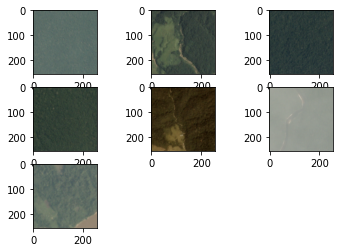

In [ ]:
#Visualize Dataset
for i in range(7):
    pyplot.subplot(330 + 1 + i)
    filename = '/content/drive/MyDrive/New folder/train-jpg/'+ 'train_' + str(i) + '.jpg'
    image = imread(filename)
    pyplot.imshow(image)
    
pyplot.show()

In [ ]:
#understanding the labels that may be assigned to each image
from pandas import read_csv
filename = '/content/drive/MyDrive/New folder/train_v2.csv/train_v2.csv'
mapping_csv = read_csv(filename)
mapping_csv = read_csv(filename)
# summarize properties
print(mapping_csv.shape)
print(mapping_csv[:10])

(40479, 2)
  image_name                                         tags
0    train_0                                 haze primary
1    train_1              agriculture clear primary water
2    train_2                                clear primary
3    train_3                                clear primary
4    train_4    agriculture clear habitation primary road
5    train_5                           haze primary water
6    train_6  agriculture clear cultivation primary water
7    train_7                                 haze primary
8    train_8        agriculture clear cultivation primary
9    train_9   agriculture clear cultivation primary road


In [ ]:
# create a set of labels
labels = set()
for i in range(len(mapping_csv)):
# convert spaced separated tags into an array of tags
   tags = mapping_csv['tags'][i].split(' ')
# add tags to the set of known labels
   labels.update(tags)
# convert set of labels to a list to list
labels = list(labels)
# order set alphabetically
labels.sort()

In [ ]:
# dict that maps labels to integers so that we can encode the training dataset for modeling.
labels_map = {labels[i]:i for i in range(len(labels))}
#create a dictionary with the reverse mapping from integers to string tag values,so later when the model makes a prediction, we can turn it 
inv_labels_map = {i:labels[i] for i in range(len(labels))}

In [ ]:
#total of 17 tags in the dataset.
print(len(labels_map))
#each tag is assigned a consistent and unique integer,The tags are descriptions of the types of features we may see in a given satellite image
print(labels_map)

17
{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}


In [ ]:
# load and prepare planet dataset and save to file
import tensorflow as tf
import keras
import numpy as np 
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from pandas import read_csv
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [ ]:
# create a mapping of tags to integers given the loaded mapping file
def create_tag_mapping(mapping_csv):
	# create a set of all known tags
	labels = set()
	for i in range(len(mapping_csv)):
		# convert spaced separated tags into an array of tags
		tags = mapping_csv['tags'][i].split(' ')
		# add tags to the set of known labels
		labels.update(tags)
	# convert set of labels to a list to list
	labels = list(labels)
	# order set alphabetically
	labels.sort()
	# dict that maps labels to integers, and the reverse
	labels_map = {labels[i]:i for i in range(len(labels))}
	inv_labels_map = {i:labels[i] for i in range(len(labels))}
	return labels_map, inv_labels_map

In [ ]:
# create a mapping of filename to a list of tags
def create_file_mapping(mapping_csv):
	mapping = dict()
	for i in range(len(mapping_csv)):
		name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
		mapping[name] = tags.split(' ')
	return mapping

In [ ]:
# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
	# create empty vector
	encoding = zeros(len(mapping), dtype='uint8')
	# mark 1 for each tag in the vector
	for tag in tags:
		encoding[mapping[tag]] = 1
	return encoding

In [ ]:
import PIL
# load all images into memory
def load_dataset(path, file_mapping, tag_mapping):
	photos, targets = list(), list()
	# enumerate files in the directory
	for filename in listdir(folder):
		# load image
		photo = load_img(path + filename)
		# convert to numpy array
		photo = img_to_array(photo, dtype='uint8')
		# get tags
		tags = file_mapping[filename[:-4]]
		# one hot encode tags
		target = one_hot_encode(tags, tag_mapping)
		# store
		photos.append(photo)
		targets.append(target)
	X = asarray(photos, dtype='uint8')
	y = asarray(targets, dtype='uint8')
	return X, y

In [ ]:

# load the mapping file
filename = '/content/drive/MyDrive/New folder/train_v2.csv/train_v2.csv'
mapping_csv = read_csv(filename)
# create a mapping of tags to integers
tag_mapping, _ = create_tag_mapping(mapping_csv)
# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(mapping_csv)
# load the jpeg images
folder = '/content/drive/MyDrive/New folder/train-jpg/'
X, y= load_dataset(folder, file_mapping, tag_mapping)
print(X.shape, y.shape)
# save both arrays to one file in compressed format
savez_compressed('/content/drive/MyDrive/New folder/planet_data.npz', X, y)

(8, 256, 256, 3) (8, 17)


In [ ]:
# test f-beta score
import sys
from numpy import load
from numpy import ones
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from matplotlib import pyplot
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('/content/drive/MyDrive/New folder/planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# load dataset
trainX, trainY, testX, testY = load_dataset()
# make all one predictions
train_yhat = asarray([ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = asarray([ones(testY.shape[1]) for _ in range(testY.shape[0])])
# evaluate predictions
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

(5, 256, 256, 3) (5, 17) (3, 256, 256, 3) (3, 17)
All Ones: train=0.520, test=0.584


In [ ]:
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

In [ ]:
# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(out_shape, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model
model=define_model(in_shape=(128, 128, 3), out_shape=17)

In [ ]:
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterators
	train_it = datagen.flow(trainX, trainY, batch_size=128)
	test_it = datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
	validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

(5, 256, 256, 3) (5, 17) (3, 256, 256, 3) (3, 17)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


InvalidArgumentError: ignored

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = 'new'
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [ ]:

from IPython.display import Image
Image('new_plot.png')